In [25]:
import pandas as pd
import numpy as np
import joblib as jb
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
BASE_DIR = 'digits_jpeg'
TARGET_SIZE = (8, 8)

In [3]:
def load_digit_images(folder_path, img_size=(28, 28)):
    data = []
    folder = Path(folder_path)

    for class_folder in sorted(folder.iterdir()):
        if class_folder.is_dir():
            try:
                label = int(class_folder.name)

                image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
                image_files = []
                for ext in image_extensions:
                    image_files.extend(class_folder.glob(ext))
                
                count = 0
                for img_path in image_files:
                    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
                    
                    if img is not None:
                        img = cv2.resize(img, img_size)
                        img_flat = img.flatten()

                        row = {'label': label, 'filename': img_path.name}
                        for i, pixel in enumerate(img_flat):
                            row[f'pixel_{i}'] = pixel
                        
                        data.append(row)
                        count += 1
                
            except ValueError:
                print(f"Skipping folder '{class_folder.name}' (not a valid digit)")
                continue
    
    df = pd.DataFrame(data)
    print(f"\nDataFrame created with shape: {df.shape}")
    print(f"Columns: label, filename, pixel_0 to pixel_{img_size[0]*img_size[1]-1}")
    
    return df

In [4]:
df = load_digit_images(BASE_DIR)
df.head()


DataFrame created with shape: (10157, 786)
Columns: label, filename, pixel_0 to pixel_783


,label,filename,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,...,pixel_774,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783
0,0,img001-00001.jpeg,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,0,img001-00002.jpeg,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,0,img001-00003.jpeg,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,0,img001-00004.jpeg,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,0,img001-00005.jpeg,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


In [5]:
X = df.drop(['label', 'filename'], axis=1)
y = df['label']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train,X_dev,y_train,y_dev = train_test_split(X_train,y_train,test_size = 0.125, random_state=42)

scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_dev_sc = scaler.transform(X_dev)
X_test = scaler.transform(X_test)

In [11]:
model_svc = SVC(probability=True)

model_svc.fit(X_train_sc,y_train)
y_pred = model_svc.predict(X_dev_sc)
y_proba = model_svc.predict_proba(X_dev_sc)

f1 = f1_score(y_dev,y_pred,average='macro')
rocAuc = roc_auc_score(y_dev,y_proba,multi_class='ovo')
print(f"Score of SVC in f1 metrics: {f1:.2f} and rocAuc: {rocAuc:.2f}")

Score of SVC in f1 metrics: 0.95 and rocAuc: 1.00


In [12]:
model_rf = RandomForestClassifier(random_state=42)

model_rf.fit(X_train_sc,y_train)
y_pred = model_rf.predict(X_dev_sc)
y_proba = model_rf.predict_proba(X_dev_sc)

f1 = f1_score(y_dev,y_pred,average='macro')
rocAuc = roc_auc_score(y_dev,y_proba,multi_class='ovo')
print(f"Score of Random Forest in f1 metrics: {f1:.2f} and rocAuc: {rocAuc:.2f}")

Score of Random Forest in f1 metrics: 0.98 and rocAuc: 1.00


In [38]:
def predict_new(image_path, scaler, model,model2):
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        print("Error: Image not found.")
        return

    _, img_binary = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)

    kernel = np.ones((3, 3), np.uint8)
    img_thick = cv2.dilate(img_binary, kernel, iterations=1)
    img_final_processed = cv2.bitwise_not(img_thick)
    img_resized = cv2.resize(img_final_processed, (28, 28), interpolation=cv2.INTER_AREA)

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.subplot(1, 2, 2)
    plt.title("Thickened & Resized")
    plt.imshow(img_resized, cmap='gray', vmin=0, vmax=255)
    plt.show()

    img_flat = img_resized.flatten().reshape(1, -1)
    img_scaled = scaler.transform(img_flat)

    prediction1 = model.predict(img_scaled)[0]
    probabilities1 = model.predict_proba(img_scaled)[0]
    confidence1 = np.max(probabilities1) * 100

    prediction2 = model2.predict(img_scaled)[0]
    probabilities2 = model2.predict_proba(img_scaled)[0]
    confidence2 = np.max(probabilities2) * 100

    print(f"Prediction for model1: {prediction1}")
    print(f"Confidence for model1: {confidence1:.2f}%")

    print(f"Prediction for model2: {prediction2}")
    print(f"Confidence for model2: {confidence2:.2f}%")
    
    return prediction1,prediction2

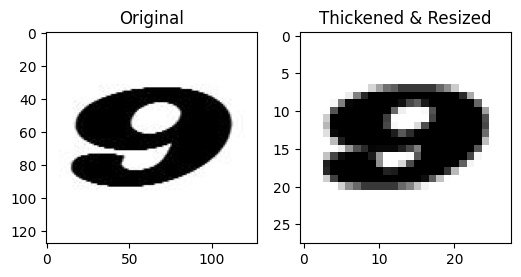

Prediction for model1: 9
Confidence for model1: 35.00%
Prediction for model2: 0
Confidence for model2: 20.39%


d:\Projects\DIGITS\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


(np.int64(9), np.int64(0))

In [39]:
predict_new('img010-01008.jpeg', scaler, model_rf,model_svc)

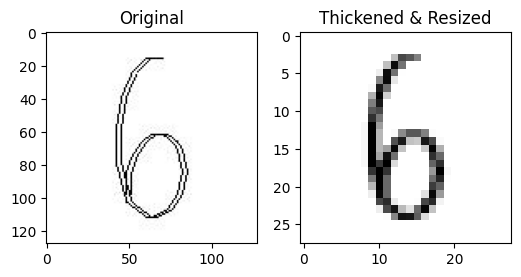

Prediction for model1: 6
Confidence for model1: 37.00%
Prediction for model2: 6
Confidence for model2: 94.51%


d:\Projects\DIGITS\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


(np.int64(6), np.int64(6))

In [40]:
predict_new('img007-00878.jpeg', scaler, model_rf,model_svc)

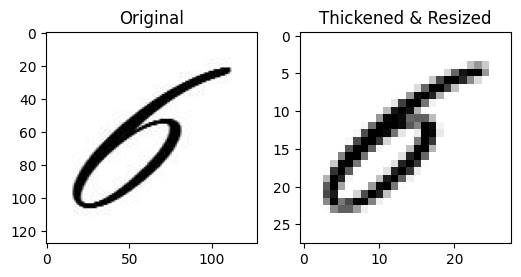

Prediction for model1: 6
Confidence for model1: 50.00%
Prediction for model2: 6
Confidence for model2: 75.42%


d:\Projects\DIGITS\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


(np.int64(6), np.int64(6))

In [41]:
predict_new('img007-00999.jpeg', scaler, model_rf,model_svc)

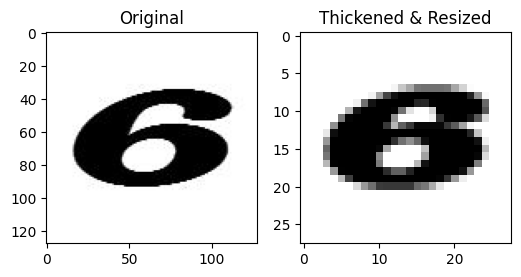

Prediction for model1: 6
Confidence for model1: 55.00%
Prediction for model2: 0
Confidence for model2: 21.21%


d:\Projects\DIGITS\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


(np.int64(6), np.int64(0))

In [42]:
predict_new('img007-01007.jpeg', scaler, model_rf,model_svc)